In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,learning_curve

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

## Import des données

In [93]:
df = pd.read_csv('../data/data_clear.csv')

In [94]:
df= df.sample(n= 50000,random_state=42)

## Train Test Split

In [95]:
X = df.drop(['City', 'CreateJob','RetainedJob', 'RevLineCr',"is_default"], axis=1)
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True,stratify=y, random_state=42)

Séparation en categories

In [96]:
numeric_features = ["Term","NoEmp","GrAppv", 'have_franchise', 'in_recession', "LowDoc"]
categorial_features = ["State","BankState","NewExist","UrbanRural","sector"]

Création preprocessor

In [97]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [98]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features)
    ]
   , remainder="passthrough" 
)

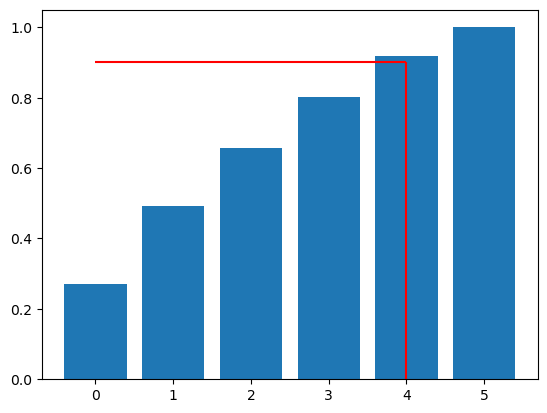

In [99]:
from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

# XGBoost

In [100]:
from xgboost import XGBClassifier
numeric_transformer = Pipeline([
        ('standard', StandardScaler()),  # Centrer réduire
        ('pca', PCA(n_components=4)) # après standardisation
        ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ],
    remainder="passthrough" 
)
bst = XGBClassifier(n_estimators=201, max_depth=6, objective='binary:logistic',random_state=42,n_jobs=-2)
pipe_xgboost = Pipeline([
     ('preprocessor', preprocessor),
     ('xgboost', bst)
])

recherche des meilleur params

In [101]:
from sklearn.model_selection import GridSearchCV

parameters = {"xgboost__learning_rate":[0.125,0.15,0.175],"xgboost__scale_pos_weight":[1.75,2,2.25,2.5]}
grid_src = GridSearchCV(estimator=pipe_xgboost, param_grid=parameters,scoring='f1_macro',cv=5,verbose=2)
grid_src.fit(X_train, y_train)

pipe_xgboost.set_params(**grid_src.best_params_)
print(grid_src.best_params_)
# best={'xgboost__learning_rate': 0.125, 'xgboost__scale_pos_weight': 1.5}
# pipe_xgboost.set_params(**best)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   3.3s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   3.1s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   3.2s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   4.4s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   4.0s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   4.0s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   6.5s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   3.7s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   3.7s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   3.9s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_

In [102]:
pipe_xgboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'have_franchise',
                                                   'in_recession', 'LowDoc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'NewExist', 'UrbanRural',
                                                   'sector'])])),
                ('xgbo...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.175, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=201, n_jobs=-2,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

## Creation instance mlflow

In [103]:
import mlflow
experiment_id=mlflow.get_experiment_by_name("loan_analysis").experiment_id

In [104]:
from sklearn.metrics import f1_score

In [105]:
with mlflow.start_run(experiment_id=experiment_id) as run:


    for param,value in pipe_xgboost[-1].get_params().items():
        mlflow.log_param(param, value)
    mlflow.log_param("PCA", True)

    mlflow.log_metric("Score_test",f1_score(y_test,pipe_xgboost.predict(X_test), average="macro"))


## Scoring

In [106]:
from sklearn.model_selection import cross_val_predict
# Utilisation de cross val predict pour gener les predictions du train
pred = cross_val_predict(pipe_xgboost,X_train,y_train,cv=5)

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train,y_pred=pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     37129
           1       0.71      0.68      0.69      7871

    accuracy                           0.89     45000
   macro avg       0.82      0.81      0.81     45000
weighted avg       0.89      0.89      0.89     45000



In [108]:
print(classification_report(y_true=y_train,y_pred=pipe_xgboost.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37129
           1       0.81      0.81      0.81      7871

    accuracy                           0.93     45000
   macro avg       0.89      0.89      0.89     45000
weighted avg       0.93      0.93      0.93     45000



In [109]:
print(classification_report(y_true=y_test,y_pred=pipe_xgboost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4126
           1       0.68      0.67      0.67       874

    accuracy                           0.89      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.89      0.89      0.89      5000



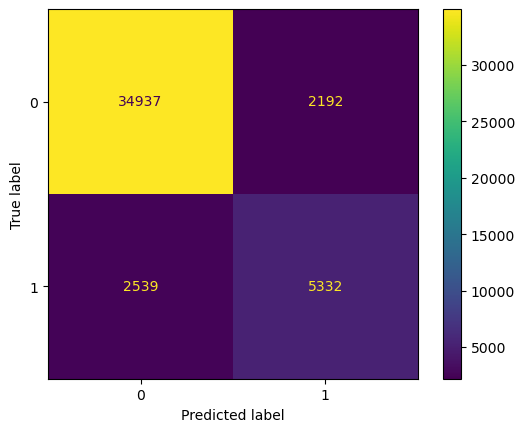

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_train,y_pred=pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_xgboost[-1].classes_)
disp.plot()

plt.show()

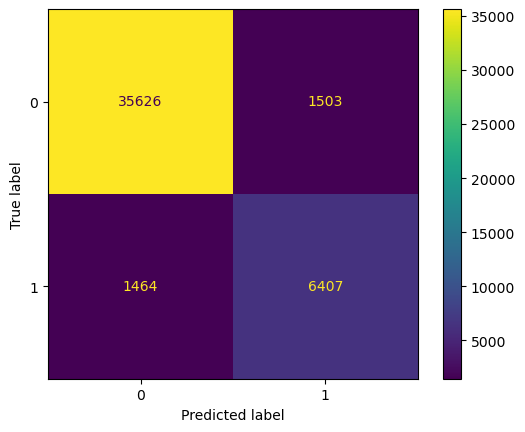

In [111]:
cm = confusion_matrix(y_true=y_train,y_pred=pipe_xgboost.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_xgboost[-1].classes_)
disp.plot()

plt.show()

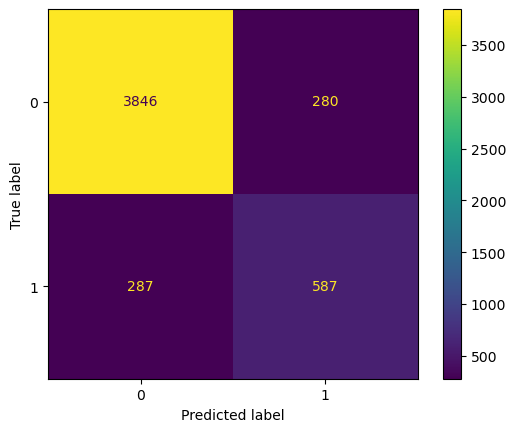

In [112]:
cm = confusion_matrix(y_true=y_test,y_pred=pipe_xgboost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_xgboost[-1].classes_)
disp.plot()

plt.show()

### Affichage des learning curve

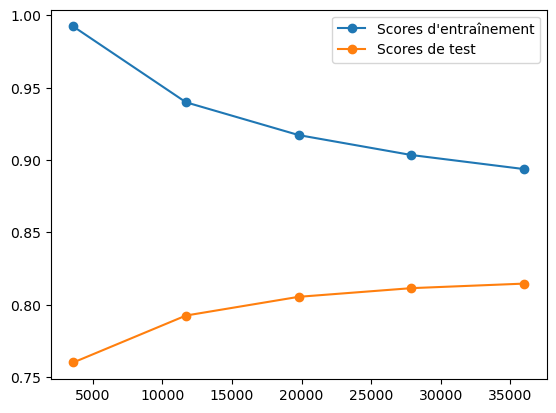

In [113]:
train_sizes, train_scores, test_scores = learning_curve(
    pipe_xgboost, X_train, y_train, cv=5, scoring='f1_macro',train_sizes=np.linspace(0.1,1,5))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', label='Scores d\'entraînement')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Scores de test')
plt.legend()
plt.show()

### Affichage des feature importance

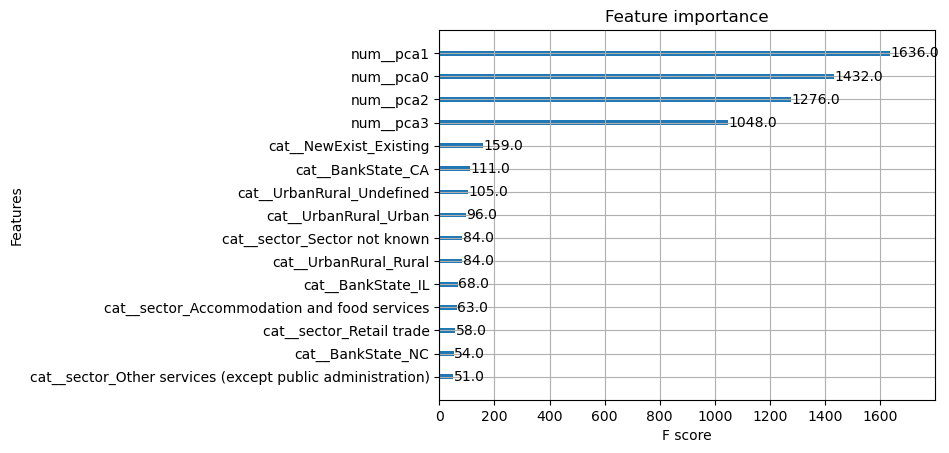

In [114]:
from xgboost import plot_importance

pipe_xgboost[-1].get_booster().feature_names = list(pipe_xgboost[0].get_feature_names_out())
plot_importance(pipe_xgboost[-1],max_num_features=15)
plt.show()